In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [2]:
columns = ['x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df1 = pd.read_csv('raj_task.csv', header = None, names = columns)
df2 = pd.read_csv('raj_task_1.csv', header = None, names = columns)
df3 = pd.read_csv('raj_walking.csv', header = None, names = columns)
df4 = pd.read_csv('raj_sitting.csv', header = None, names = columns)
#df5 = pd.read_csv('dataset/new_action.csv', header = None, names = columns)
df = pd.concat([df1, df2, df3,df4], ignore_index= True)
#df  = df.iloc[1:]
df = df.dropna()

In [3]:
df.head()

,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,-0.844,0.086,0.474,0.549,1.402,0.122,1
1,-0.837,0.081,0.485,0.000,0.854,0.244,1
2,-0.843,0.083,0.477,-0.244,-1.098,0.061,1
3,-0.842,0.083,0.475,0.061,-0.915,-0.122,1
4,-0.851,0.088,0.468,0.549,0.854,0.122,1


In [4]:
df.shape

(31522, 7)

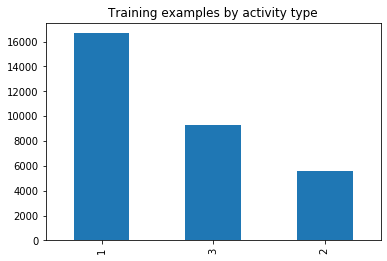

In [5]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [6]:
N_TIME_STEPS = 500
N_FEATURES = 6
step = 100
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
    ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
    zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #print label
    segments.append([xs, ys, zs, xsg, ysg, zsg])
    labels.append(label)
    #print labels

In [7]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [8]:
reshaped_segments.shape

(311, 500, 6)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
X_train.shape

(248, 500, 6)

In [11]:
X_test.shape

(63, 500, 6)

In [12]:
N_CLASSES = 3
N_HIDDEN_UNITS = 64

In [13]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [14]:

#tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [15]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

W0912 15:10:01.332819 140736334603200 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0912 15:10:01.334079 140736334603200 deprecation.py:323] From <ipython-input-13-c8ae7df74e6e>:17: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0912 15:10:01.336033 140736334603200 deprecation.py:323] From <ipython-input-13-c8ae7df74e6e>:18: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructio

In [16]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

W0912 15:10:22.857893 140736334603200 deprecation.py:323] From <ipython-input-16-4720b2143aa0>:6: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [17]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [18]:
N_EPOCHS = 20
BATCH_SIZE = 128

In [19]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    #if i != 1 and i % 10 != 0:
        #continue

    print("epoch " + str(i) + ":  "+ "test accuracy:" + " " + str(acc_test) + " " + "loss:" + str(loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

#print()
print("final results: accuracy:   " + str(acc_final) + "\t" +  "loss:  " +str(loss_final))

epoch 1:  test accuracy: 0.7936508 loss:1.6894588
epoch 2:  test accuracy: 0.7777778 loss:1.120178
epoch 3:  test accuracy: 0.8730159 loss:1.1283071
epoch 4:  test accuracy: 0.9206349 loss:1.119626
epoch 5:  test accuracy: 0.84126985 loss:1.2041409
epoch 6:  test accuracy: 0.8888889 loss:1.1444571
epoch 7:  test accuracy: 0.93650794 loss:1.0750114
epoch 8:  test accuracy: 0.93650794 loss:1.0467412
epoch 9:  test accuracy: 0.93650794 loss:0.9801101
epoch 10:  test accuracy: 0.96825397 loss:0.91496706
epoch 11:  test accuracy: 0.96825397 loss:0.9066581
epoch 12:  test accuracy: 0.96825397 loss:0.8810876
epoch 13:  test accuracy: 0.95238096 loss:0.90218157
epoch 14:  test accuracy: 0.95238096 loss:0.94681656
epoch 15:  test accuracy: 0.95238096 loss:0.9760177
epoch 16:  test accuracy: 0.95238096 loss:0.97650564
epoch 17:  test accuracy: 0.95238096 loss:0.97249585
epoch 18:  test accuracy: 0.95238096 loss:0.96430296
epoch 19:  test accuracy: 0.95238096 loss:0.9635733
epoch 20:  test accura

In [20]:
pickle.dump(predictions, open("predictions_task1.p", "wb"))
pickle.dump(history, open("history_task1.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/activity_task1.pbtxt')  
saver.save(sess, save_path = "./checkpoint/activity_tesk1.ckpt")
sess.close()

In [21]:
history = pickle.load(open("history_task1.p", "rb"))
predictions = pickle.load(open("predictions_task1.p", "rb"))

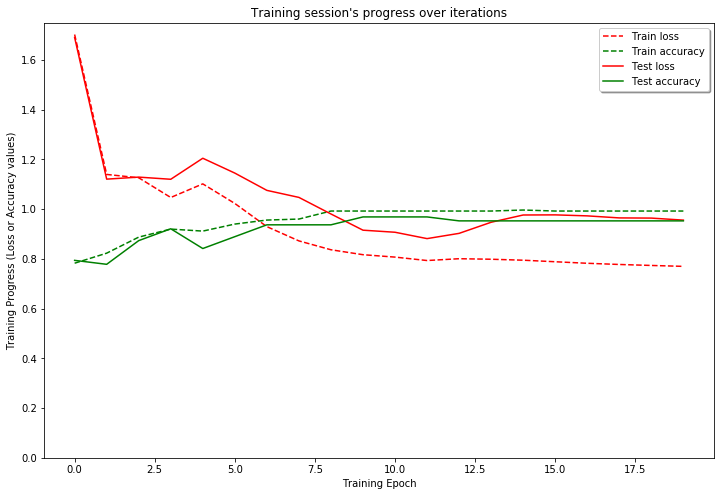

In [22]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [23]:
#activity
LABELS = ['task1','walking','sitting']

In [24]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [25]:
#max_test = np.argmax(y_test, axis=1)
#ls = list(max_test)
#ls


In [26]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

max_test1 = max_test.tolist()
print (max_test1)
print (type(max_test1))
max_predictions1 = max_predictions.tolist()
print(max_predictions1)

confusion_matrix(max_test1, max_predictions1)


[2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1, 1, 1, 2, 0, 0]
<class 'list'>
[2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 0, 0]


array([[33,  2,  0],
       [ 0, 11,  0],
       [ 1,  0, 16]])

In [27]:
def data_reshaping(df):
    #df['activity'].value_counts().plot(kind='bar', title='Testing examples by activity type');
    N_TIME_STEPS = 500
    N_FEATURES = 6
    step = 100
    segments = []
    test_labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        xs = df['x-axis'].values[i: i + N_TIME_STEPS]
        ys = df['y-axis'].values[i: i + N_TIME_STEPS]
        zs = df['z-axis'].values[i: i + N_TIME_STEPS]
        xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
        ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
        zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
        
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs, xsg, ysg,zsg])
        test_labels.append(label)
    #print test_labels
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    #test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
    #X_train, X_test, y_train, y_test = train_test_split(
        #reshaped_segments, test_labels, test_size=0.99, random_state=RANDOM_SEED)
    X_test = reshaped_segments
    y_test = test_labels
    
    #print test_labels
    return X_test, y_test
    

In [29]:
test = pd.read_csv('test_raj.csv', header = None, names = columns)

In [30]:
x_test1, y_test1 = data_reshaping(test)

In [32]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.import_meta_graph("./checkpoint/activity_tesk1.ckpt.meta")
    saver.restore(sess,tf.train.latest_checkpoint("./checkpoint"))
    predictions1= sess.run(pred_softmax, feed_dict={X: x_test1})
    #predictions, acc_final, loss_final = sess.run([pred_softmax, a, feed_dict={X: X_test1, Y: y_test1})
    sess.close()

W0912 15:27:14.769060 140736334603200 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [36]:
y_ls = list(y_test1)
print(y_ls)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [38]:
max_predictions1 = np.argmax(predictions1, axis=1) + 1
print(list(max_predictions1))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1]


In [85]:
columns = ['time','x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df_time = pd.read_csv('test_raj_time.csv', header = None, names = columns)

In [86]:
time = df_time['time']

In [87]:
single_task_list = []

In [88]:
pred_list = list(max_predictions1)
activity = []
temp = ['activity name','start time','End time','Accuracy']
activity.append(temp)

In [89]:
i = 400
for items in pred_list:
    i+=100
    if len(single_task_list) == 6:
        if single_task_list.count(1) >= single_task_list.count(2):
            accuracy = single_task_list.count(1) *100 / 6
            ls = []
            ls.append(1)
            ls.append(time[i-500])
            ls.append(time[i])
            ls.append(accuracy)
            activity.append(ls)
        single_task_list =[]
    else:
        single_task_list.append(items)
        

In [90]:
for items in activity:
    print (items)

['activity name', 'start time', 'End time', 'Accuracy']
[1, '2019-09-12T02:35:45.154', '2019-09-12T02:35:53.599', 100.0]
[1, '2019-09-12T02:35:57.260', '2019-09-12T02:36:06.686', 100.0]
[1, '2019-09-12T02:36:24.461', '2019-09-12T02:36:36.274', 83.33333333333333]
[1, '2019-09-12T02:36:39.382', '2019-09-12T02:36:48.186', 66.66666666666667]
